In [111]:

import loader
path_HE = 'C:/Users/phili/OneDrive/Uni/WS_22/Masterarbeit/Masterarbeit_Code_Philipp_Rosin/Data_set_BCI_challange/train/HE_imgs/HE'
path_IHC = 'C:/Users/phili/OneDrive/Uni/WS_22/Masterarbeit/Masterarbeit_Code_Philipp_Rosin/Data_set_BCI_challange/train/IHC_imgs/IHC'

In [124]:
from torch.utils.data import DataLoader
train_data = loader.stain_transfer_dataset( epoch = 1,
                                                        norm = True,
                                                        num_epochs = 1,
                                                        HE_img_dir = path_HE,
                                                        IHC_img_dir = path_IHC,
                                                        img_size= [64,64],
                                           )
train_data_loader = DataLoader(train_data, batch_size=1, shuffle=False) 

In [125]:
import conv_models
gen_G = conv_models.GeneratorResNet(in_channels= 3,
                                        num_residual_blocks = 6
                                        )
gen_G = gen_G.cuda()
gen_G_path = 'C:/Users/phili/OneDrive/Uni/WS_22/Masterarbeit/Masterarbeit_Code_Philipp_Rosin/torch_stain_transfer/experiment-results/Test_01/Generator_G_weights.pth'
gen_G.load_state_dict(torch.load(gen_G_path))
gen_G.eval()

HE_img, IHC_img = next(iter(train_data_loader))
print (IHC_img)
fake_IHC = gen_G(HE_img)
print(fake_IHC)



tensor([[[[ 1.0868,  0.8193,  0.6409,  ...,  0.7301,  1.0868,  1.0868],
          [ 0.6409,  0.1951, -0.1615,  ...,  0.9084,  1.0868,  1.0868],
          [ 0.5518,  0.0168, -0.4290,  ...,  1.0868,  1.0868,  1.0868],
          ...,
          [ 1.0868,  1.0868,  0.9976,  ...,  0.2843,  0.4626,  0.8193],
          [ 0.9976,  0.9084,  0.7301,  ...,  0.6409,  0.7301,  0.9976],
          [ 0.8193,  0.8193,  0.9084,  ...,  0.9976,  0.9084,  0.9976]],

         [[ 1.4412,  1.1906,  1.0236,  ...,  1.2741,  1.6082,  1.7753],
          [ 1.0236,  0.6060,  0.2719,  ...,  1.4412,  1.6082,  1.6917],
          [ 0.9401,  0.4390,  0.0214,  ...,  1.6082,  1.6082,  1.6082],
          ...,
          [ 1.2741,  1.1906,  1.0236,  ...,  0.6060,  0.7730,  0.8566],
          [ 1.0236,  0.9401,  0.7730,  ...,  0.9401,  1.0236,  1.0236],
          [ 0.8566,  0.8566,  0.9401,  ...,  1.2741,  1.1906,  1.2741]],

         [[ 0.9754,  0.6344,  0.4639,  ...,  0.6344,  0.9754,  1.2312],
          [ 0.5491,  0.0376, -

In [ ]:
import torch 
from torch import nn
import math

In [ ]:
class PatchEmbedding(nn.Module):
####### patch embedding ###########
#   - in_channels are the input channels of the images for rgb = 3
#   - patch_size is the sizes of the patches for the embedding 
#   - img_size is the size of the input image (has to be quadratic)
#   - embedding_dim are the dimentions for the embedding with embedding_dim=0 it will be automaticly calculated 
    def __init__(self, in_channels, patch_size, embedding_dim):
        super().__init__()
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
# 1) the conv layer with kernel_size = stride writes out patches of the kernels the embedding_dim should be choosen as (patch_size**2)* in_channel so that no information is lost          
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=self.embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

# 2) flatten the feature map into 1D
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)


    def forward(self, x):
      
        
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
# 3) permute the output tensor so that it has the form [batch_size, embedding_dim, num_patches]      
        return x_flattened
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def getPositionEmbedding(embedding_dim, num_patches, n=10000):
    # the n variable is scalling the values in the positional embedding in the attention is all you need paper n=10000 was choosen 
    p_embedding = torch.zeros((embedding_dim, num_patches))
    p_embedding = p_embedding.cuda()
    for k in range(embedding_dim):
        for i in torch.arange(int(num_patches/2)):
            denominator = np.power(n, 2*i/num_patches)
            p_embedding[k, 2*i] = np.sin(k/denominator)
            p_embedding[k, 2*i+1] = np.cos(k/denominator)
    
    return torch.unsqueeze(p_embedding, dim=0)

x = getPositionEncoding(embedding_dim=764, num_patches=16, n=10)


print(x.get_device())

In [ ]:
patches = PatchEmbedding(in_channels=3,patch_size=16, embedding_dim=764)
patches.cuda()
y = patches(HE_img)

print(y.shape)

In [ ]:
# d_model = embedding_dim
# nhead = attention heads 
# https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer


transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=2048,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)

transformer_decoder_layer = nn.TransformerDecoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=2048,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)

In [ ]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=12)

transformer_decoder = nn.TransformerEncoder(
    encoder_layer=transformer_decoder_layer,
    num_layers=12)

In [ ]:
class Generator(nn.Module):
###### GENERATOR CLASS #############
# 1) set up the embedding of input img :
#        - img_size is the size of the input inmage of the generator 
#        - embedding_dim : the dimentions used also in the transformer
#        - patch_size : sizes of patches cut by the embedding [img_size % patch_size != 0]
#        - create positional embedding
#
# 2) set up the the transformer encoder layer class :
#        ---> https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer
#        - the d_model = embedding_dim so that the dimentions of the embedded image and the transformer network match
#        - nhead sets the number of heads for self attention in a transformer block 
#
# 3) set up encoder class:
#        --->  https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder
#        - use the encoder-layer set up in 2) 
#        - num_layers defines the number of encoder-layers in the encoder

    def __init__(self,img_size,embedding_dim, patch_size, in_channels, dropout_embedding, nhead,num_layers):
        super(Generator, self).__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.dropout_embedding = dropout_embedding
        self.nhead = nhead
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim


        #### testting the compatebility for img_size and patch_site 
        if img_size % patch_size == 0:
            self.patch_size = patch_size
        else : 
            print('img_size / patch_size has to have no rest')

        # number of patches in image for given patchsize 
        num_patches = (img_size * img_size) // patch_size**2 
        # number of valiables in input image ( num_channels* img_height* img_width)
        num_values = in_channels * img_size**2

        if num_values % num_patches == 0:
            self.embedding_dim =  int(num_values/num_patches)
        else:
            print('num_values / patch_num has to have no rest')

        # create patches from the imput image the output by the PatchEmbedding is : [batch_size, num_patches, embedding_dim ]
        # where as the embedding_dim is choosen as patch_size**2 * in_channels 
        self.patch_embedding = PatchEmbedding(in_channels=self.in_channels,patch_size=self.patch_size, embedding_dim=self.embedding_dim)
    
        self.num_patches = (img_size * img_size) // patch_size**2 
        # positional embedding is added to keep the informatiuon of the order of the patches 
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches, self.embedding_dim))

        self.embedding_dropout = nn.Dropout(p=self.dropout_embedding)

        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model= self.embedding_dim,
                                                               nhead=self.nhead ,
                                                               dim_feedforward=2048,
                                                               dropout=0.1,
                                                               activation="gelu",
                                                               batch_first=True,
                                                               norm_first=True)
        
        self.transformer_encoder = nn.TransformerEncoder(
                                                    encoder_layer=self.transformer_encoder_layer,
                                                    num_layers=self.num_layers)
        
        self.upsample = nn.PixelShuffle(self.num_patches)
        
        #self.linear = nn.Sequential(nn.Conv2d(self.embedding_dim, 3, 1, 1, 0))

    def forward(self, x):
        batch_size = x.shape[0]

        # Create the patch embedding
        x = self.patch_embedding(x)

        x = self.positional_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = x.permute(0, 2, 1)

        x = x.view(1, self.embedding_dim, int(math.sqrt(self.num_patches)), int(math.sqrt(self.num_patches)))

        x = self.upsample(x)

        
        return x
    



        

        

In [ ]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=2048,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)
transformer_encoder_layer.cuda()

In [110]:
from torch import nn
import os
import torch 
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

path_HE = 'C:/Users/phili/OneDrive/Uni/WS_22/Masterarbeit/Masterarbeit_Code_Philipp_Rosin/Data_set_BCI_challange/train/HE_imgs/HE'
path_IHC = 'C:/Users/phili/OneDrive/Uni/WS_22/Masterarbeit/Masterarbeit_Code_Philipp_Rosin/Data_set_BCI_challange/train/IHC_imgs/IHC'

patch_size = 512
size = patch_size
stride = patch_size
lst = os.listdir(path_IHC)
img_names = lst

HE_img_path = os.path.join(path_HE, img_names[99])
IHC_img_path = os.path.join(path_IHC, img_names[1])




def load_image_to_tensor(img_path):
    pil_img = Image.open(img_path)
    img_arr = np.array(pil_img)
    # type conversion
    img_arr = img_arr.astype(np.float32)
    # rearange dims for tensor 
    img_arr = np.transpose(img_arr, axes=[2,0,1])

    # get tensor 
    img_tensor = torch.tensor(img_arr)

    img_tensor = img_tensor.cuda()
    return img_tensor

img = load_image_to_tensor(HE_img_path)
mean, std = img.mean([1,2]), img.std([1,2])
print(mean)
print(std[1])
# normalise image 
normalise_img = transforms.Normalize(mean,std)
img_norm = normalise_img(img)

patches = img_norm.unfold(1, size, stride).unfold(2, size, stride)
print(patches.shape)
patches_1 = patches.reshape(3,4,512,512)
patches_1 = torch.permute(patches_1,(1,0,2,3))
patches = patches.reshape(4,3,512,512)
a = patches[2,:,:,:]
b = patches_1[0,:,:,:]
a = a.unsqueeze(0)
b=b.unsqueeze(0)
print(a.shape)



tensor([174., 174., 176.], device='cuda:0')
tensor(0., device='cuda:0')


ValueError: std evaluated to zero after conversion to torch.float32, leading to division by zero.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 1024, 1024])
tensor([[[174., 174., 174.,  ..., 174., 174., 174.],
         [174., 174., 174.,  ..., 174., 174., 174.],
         [174., 174., 174.,  ..., 174., 174., 174.],
         ...,
         [174., 174., 174.,  ..., 174., 174., 174.],
         [174., 174., 174.,  ..., 174., 174., 174.],
         [174., 174., 174.,  ..., 174., 174., 174.]],

        [[174., 174., 174.,  ..., 174., 174., 174.],
         [174., 174., 174.,  ..., 174., 174., 174.],
         [174., 174., 174.,  ..., 174., 174., 174.],
         ...,
         [174., 174., 174.,  ..., 174., 174., 174.],
         [174., 174., 174.,  ..., 174., 174., 174.],
         [174., 174., 174.,  ..., 174., 174., 174.]],

        [[176., 176., 176.,  ..., 176., 176., 176.],
         [176., 176., 176.,  ..., 176., 176., 176.],
         [176., 176., 176.,  ..., 176., 176., 176.],
         ...,
         [176., 176., 176.,  ..., 176., 176., 176.],
         [176., 176., 176.,  ..., 176., 176., 176.],
         [176., 176., 176

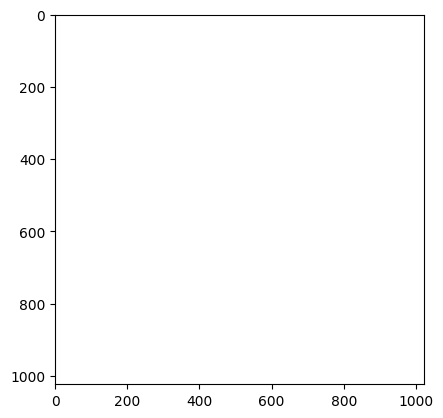

In [109]:
import matplotlib.pyplot as plt
def display_image(images):
  images_np = images.cpu().numpy()
  images_np = images_np.transpose(1,2,0)
  #img_plt = images_np.transpose(0,2,3,1)
  # display 5th image from dataset
  plt.imshow(images_np)
print(img.shape)
print(img)
display_image(img)

C:\Users\phili\AppData\Local\Temp\ipykernel_19268\4070400099.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


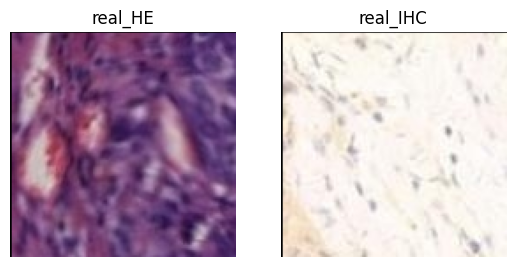

In [11]:
import loader
from torch.utils.data import DataLoader
import utils
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


real_HE = real_HE.cpu().detach().numpy()
#fake_IHC = fake_IHC.cpu().detach().numpy()
real_IHC = real_IHC.cpu().detach().numpy()

real_HE = np.squeeze(real_HE )
#fake_IHC = np.squeeze(fake_IHC)
real_IHC = np.squeeze(real_IHC )

real_HE = np.transpose(real_HE, axes=[1,2,0])
#fake_IHC = np.transpose(fake_IHC, axes=[1,2,0])
real_IHC = np.transpose(real_IHC, axes=[1,2,0])

figure.add_subplot(1, 2, 1)
        
plt.imshow(real_HE )
plt.axis('off')
plt.title('real_HE')

#figure.add_subplot(rows, columns, p)       
#plt.imshow(fake_IHC )
#plt.axis('off')
#plt.title('fake_IHC')
        

figure.add_subplot(1, 2, 2)    
plt.imshow(real_IHC )
plt.axis('off')
plt.title('real_IHC')

figure.show()

In [ ]:
class DatasetTiles(torch.utils.data.Dataset):
    """
    Dataset in wich each tile is seen as a sample. 
    """
    def _init_(self, file_paths, labels,
                 transform=None):
        """
        :param file_paths: (list) of paths to tiles. 
        :param labels: (list) of corresponding labels. 
        :param transform: pytorch compatible image transforms
            or Albumentations compose transform. 
        """
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

        assert len(file_paths) == len(labels)

        if not isinstance(labels, list):
            self.labels = labels.tolist()

        if isinstance(transform, A.core.composition.Compose) \
                or isinstance(transform, ToTensorV2):
            self.is_album = True
        else:
            self.is_album = False

        #if isinstance(self.labels, list):
        #    self.labels = np.asarray(self.labels)
 
        #if len(self.labels.shape) < 2:
        #    self.labels = np.expand_dims(self.labels, axis=0)
        
        #self.labels = self.labels.tolist()

    def _len_(self):
        """
        Get number of samples in dataset. 
        """
        return len(self.file_paths)

    def _getitem_(self, index):
        """
        Get a pair of image and sample, 
        applying transform if provided. 
        """

        path_img = self.file_paths[index]
        image = load_img(path_img)
        target = self.labels[index]

        if self.transform is not None:
            if self.is_album:
                image = self.transform(image=image)['image']
            else:
                image = self.transform(image)

        return image, target